In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
def get_delta(location, destination, grid_size):
    """
    get the horizontal and vertical distance
    between location and destination.
    """
    delta = [0, 0]
    
    for i in range(2):
        # 1st option: destination to the east/south of location
        if destination[i] > location[i]:
            # two possible distances, going east/south or
            # going west/north
            possible_delta = [destination[i] - location[i], 
                              location[i] + grid_size[i] - destination[i]]
            # if the first distance is the smallest, pick it
            if min(possible_delta) == possible_delta[0]:
                delta[i] = possible_delta[0]
            # if seconde distance is the smallest, pick minus it
            # (the agent will have to go west/north to get to a point
            #  to the east/south)
            else:
                delta[i] = -possible_delta[1]
        # 2nd option: destination to the west/north of location
        else:
            # two possible distances, going west/north or
            # going east/south
            possible_delta = [location[i] - destination[i],
                              destination[i] + grid_size[i] - location[i]]
            # if the first distance is the smallest, pick minus it
            # (the agent will have to go west/north)
            if min(possible_delta) == possible_delta[0]:
                delta[i] = -possible_delta[0]
            # if second distance is smallest, pick it
            else:
                delta[i] = possible_delta[1]
    # return a tuple
    return tuple(delta)

In [3]:
def get_distance(delta):
    return sum([abs(i) for i in delta])

In [4]:
def get_reward(location, destination, grid_size, deadline):
    delta = get_delta(location, destination, grid_size)
    distance = get_distance(delta)
    if distance:
        reward = -distance
    else:
        reward = deadline
    return reward

In [5]:
def get_next_point(position, heading, grid_size, action):
    next_point = list(position)
    next_heading = list(heading)
    if action == 'forward':
        next_point = [(next_point[i] + heading[i]) % grid_size[i]
                      for i in range(2)]
    elif action == 'right':
        if heading[0]: #turned to EW axis
            next_point[1] = (next_point[1] + heading[0]) % grid_size[1]
            next_heading = [heading[1], heading[0]]
        else: # turned to NS axis
            next_point[0] = (next_point[0] - heading[1]) % grid_size[0]
            next_heading = [-heading[1], heading[0]]
    elif action == 'left':
        if heading[0]:
            next_point[1] = (next_point[1] - heading[0]) % grid_size[1]
            next_heading = [heading[1], -heading[0]]
        else:
            next_point[0] = (next_point[0] + heading[1]) % grid_size[0]
            next_heading = [heading[1], heading[0]]
    elif action != None:
        raise ValueError('Invalid action.')
    
    next_point = [grid_size[i] if next_point[i] == 0 else next_point[i]
                  for i in range(2)]

    return tuple(next_point), tuple(next_heading)

In [6]:
GRID = (8, 6)
POSSIBLE_ACTIONS = (None, 'forward', 'left', 'right')
N_TRIALS = 100000
DEADLINE = 100

In [7]:
def get_random_position(grid_size):
    return tuple([random.choice(range(number)) + 1
                  for number in grid_size])

In [8]:
def simulate(trials, grid_size, deadline, planner_func, qval_func):
    trial_results = []
    qvals = {}
    
    for i in range(trials):
        location = get_random_position(grid_size)
        destination = get_random_position(grid_size)
        while destination == location:
            destination = get_random_position(grid_size)        
        axis = random.choice(range(2))
        heading = tuple([0 if i != axis else random.choice([-1, 1])
                        for i in range(2)])
        reward_sum = 0
        sum_time_left = 0
        
        for i in range(deadline):
            delta = get_delta(location, destination, grid_size)
            state = (delta, heading)
            action = planner_func(state, qvals)
            location, heading = get_next_point(location, heading, grid_size, action)
            next_state = (location, heading)
            reward = get_reward(location, destination, grid_size, deadline - i)
            qval_infos = (state, action, reward, next_state)
            qvals = qval_func(qvals, qval_infos, i)
            reward_sum += reward
            if location == destination:
                sum_time_left += deadline - i - 1
                break
        trial_results.append((i+1, reward_sum, sum_time_left))
    
    df = pd.DataFrame(trial_results)
    df.columns = ['n_steps', 'reward_sum', 'sum_time_left']
    return df, qvals

In [9]:
def random_planner(state, qvals):
    return random.choice(POSSIBLE_ACTIONS)

def no_qval_update(qvals, qval_infos, i):
    state, action, _, _ = qval_infos
    qvals[(state, action)] = qvals.get((state, action), 0) + 1
    return qvals

df_random, random_qvals = simulate(N_TRIALS, GRID, DEADLINE, random_planner, no_qval_update)
print "Destinations reached: {} of {}".format(sum(df_random['n_steps']<DEADLINE), N_TRIALS)
print "Positive sums of rewards: {} of {}".format(sum(df_random['reward_sum']>0), N_TRIALS)
print "States visited: {}".format(len(random_qvals))
df_random.describe()

Destinations reached: 79432 of 100000
Positive sums of rewards: 30769 of 100000
States visited: 992


,n_steps,reward_sum,sum_time_left
count,100000.000000,100000.000000,100000.000000
mean,50.369340,-133.383460,49.630660
std,34.810659,173.980217,34.810659
min,1.000000,-507.000000,0.000000
25%,19.000000,-308.000000,13.000000
50%,44.000000,-99.000000,56.000000
75%,87.000000,25.000000,81.000000
max,100.000000,100.000000,99.000000


In [10]:
df_random_qvals = pd.DataFrame.from_dict(random_qvals, orient='index')
df_random_qvals.describe()

,0
count,992.000000
mean,5077.554435
std,1935.208060
min,152.000000
25%,3586.000000
50%,4711.500000
75%,6984.500000
max,7754.000000


In [11]:
def perfect_planner(state, qvals):
    delta, heading = state
    # if agent is turned to the east/west axis
    if heading[0]:
        # if it needs to go forward, do it
        if delta[0] * heading[0] > 0:
            return 'forward'
        # else check if it needs to go backward
        elif delta[0] * heading[0] < 0:
            if delta[1] * heading[0] > 0:
                return 'right'
            else:
                return 'left'
        elif delta[1] * heading[0] > 0:
            return 'right'
        else:
            return 'left'
    else:
        if delta[1] * heading[1] > 0:
            return 'forward'
        elif delta[1] * heading[1] < 0:
            if delta[0] * heading[1] < 0:
                return 'right'
            else:
                return 'left'
        elif delta[0] * heading[1] < 0:
            return 'right'
        else:
            return 'left'

df_perfect, perfect_qvals = simulate(N_TRIALS, GRID, DEADLINE, perfect_planner, no_qval_update)
print "Destinations reached: {} of {}".format(sum(df_perfect['n_steps']<DEADLINE), N_TRIALS)
print "Positive sums of rewards: {} of {}".format(sum(df_perfect['reward_sum']>0), N_TRIALS)
print "States visited: {}".format(len(perfect_qvals))
df_perfect.describe()

Destinations reached: 100000 of 100000
Positive sums of rewards: 100000 of 100000
States visited: 248


,n_steps,reward_sum,sum_time_left
count,100000.000000,100000.000000,100000.000000
mean,3.700340,91.273360,96.299660
std,1.435425,6.219008,1.435425
min,1.000000,73.000000,93.000000
25%,3.000000,86.000000,95.000000
50%,4.000000,91.000000,96.000000
75%,5.000000,95.000000,97.000000
max,7.000000,100.000000,99.000000


In [12]:
df_perfect_qvals = pd.DataFrame.from_dict(perfect_qvals, orient='index')
df_perfect_qvals.describe()

,0
count,248.000000
mean,1492.072581
std,2413.924966
min,116.000000
25%,276.000000
50%,549.000000
75%,1731.000000
max,18059.000000


In [19]:
def learning_planner(state, qvals):
    possible_vals = {action: qvals.get((state, action), 0)
                     for action in POSSIBLE_ACTIONS}
    best_actions = [action for action in possible_vals.keys()
                    if possible_vals[action] == max(possible_vals.values())]
    return random.choice(best_actions)

def basic_qval_update(qvals, qval_infos, i):
    learn_rate = 1.0
    discount_rate = 0.99
    state, action, reward, next_state = qval_infos
    current_qval = qvals.get((state, action), 0)
    next_action = learning_planner(next_state, qvals)
    
    update_qval = (1-learn_rate) * current_qval + \
    learn_rate * (reward + discount_rate * qvals.get((next_state, next_action), 0))
    
    qvals[(state, action)] = update_qval
    return qvals

df_learning, learning_qvals = simulate(N_TRIALS, GRID, DEADLINE, learning_planner, basic_qval_update)
print "Destinations reached: {} of {}".format(sum(df_learning['n_steps']<DEADLINE), N_TRIALS)
print "Positive sums of rewards: {} of {}".format(sum(df_learning['reward_sum']>0), N_TRIALS)
print "States visited: {}".format(len(learning_qvals))
df_learning.describe()

Destinations reached: 33839 of 100000
Positive sums of rewards: 33830 of 100000
States visited: 973


,n_steps,reward_sum,sum_time_left
count,100000.000000,100000.000000,100000.000000
mean,67.323510,-190.412700,32.676490
std,45.710888,217.394861,45.710888
min,1.000000,-700.000000,0.000000
25%,4.000000,-396.000000,0.000000
50%,100.000000,-300.000000,0.000000
75%,100.000000,91.000000,96.000000
max,100.000000,100.000000,99.000000


In [20]:
learning_qvals

{(((-4, -3), (-1, 0)), None): -7.0,
 (((-4, -3), (-1, 0)), 'forward'): -6.0,
 (((-4, -3), (-1, 0)), 'left'): -6.0,
 (((-4, -3), (-1, 0)), 'right'): -6.0,
 (((-4, -3), (0, -1)), None): -7.0,
 (((-4, -3), (0, -1)), 'forward'): -6.0,
 (((-4, -3), (0, -1)), 'left'): -6.0,
 (((-4, -3), (0, -1)), 'right'): -6.0,
 (((-4, -3), (0, 1)), None): -7.0,
 (((-4, -3), (0, 1)), 'forward'): -6.0,
 (((-4, -3), (0, 1)), 'left'): -6.0,
 (((-4, -3), (0, 1)), 'right'): -6.0,
 (((-4, -3), (1, 0)), None): -7.0,
 (((-4, -3), (1, 0)), 'forward'): -6.0,
 (((-4, -3), (1, 0)), 'left'): -6.0,
 (((-4, -3), (1, 0)), 'right'): -6.0,
 (((-4, -2), (-1, 0)), None): -6.0,
 (((-4, -2), (-1, 0)), 'forward'): -9.95,
 (((-4, -2), (-1, 0)), 'left'): -7.0,
 (((-4, -2), (-1, 0)), 'right'): -5.0,
 (((-4, -2), (0, -1)), None): -6.0,
 (((-4, -2), (0, -1)), 'forward'): -5.0,
 (((-4, -2), (0, -1)), 'left'): -11.9003,
 (((-4, -2), (0, -1)), 'right'): -14.820998000000001,
 (((-4, -2), (0, 1)), None): -6.0,
 (((-4, -2), (0, 1)), 'forwar

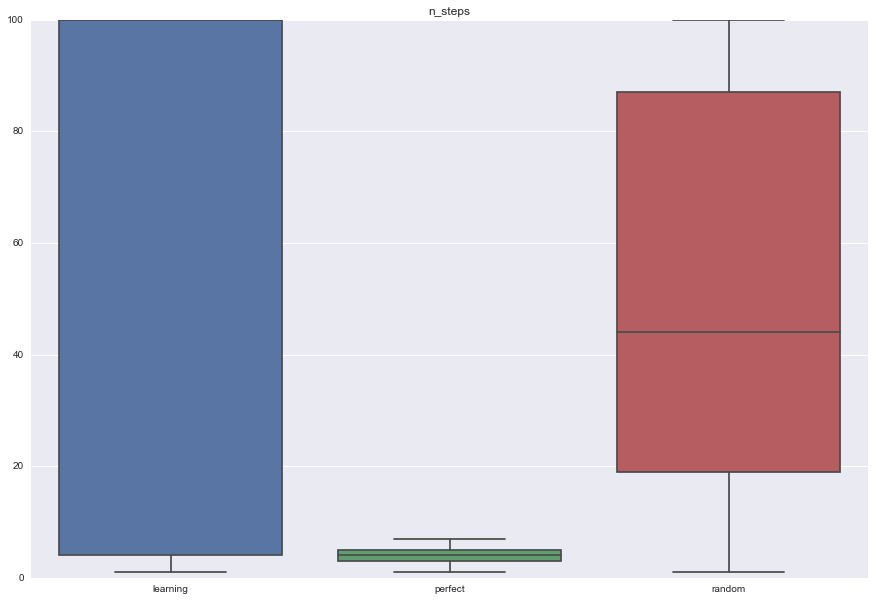

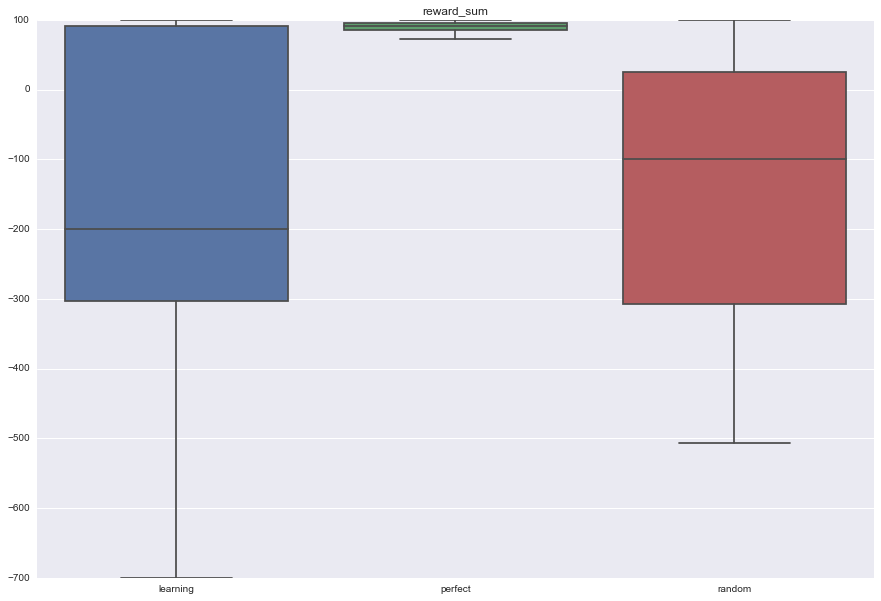

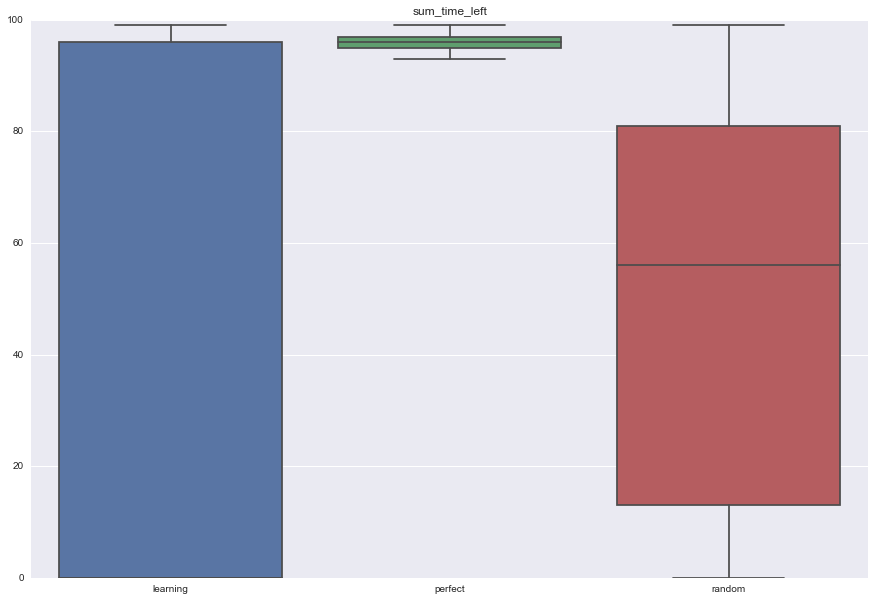

In [15]:
results = {'perfect': df_perfect, 'random': df_random, 'learning': df_learning}

panel = pd.Panel(results)

for column in df_perfect.columns:
    sns.boxplot(data=panel.minor_xs(column))
    plt.title(column)
    plt.show()
    plt.close()